In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("YourCabs.csv")

In [3]:
# Percentage of Nulls for all the columns
(df.isnull().sum()/(len(df)))*100

id                      0.000000
user_id                 0.000000
vehicle_model_id        0.000000
package_id             82.616104
travel_type_id          0.000000
from_area_id            0.202620
to_area_id             21.040271
from_city_id           62.365591
to_city_id             96.343626
from_date               0.000000
online_booking          0.000000
mobile_site_booking     0.000000
booking_created         0.000000
from_lat                0.214133
from_long               0.214133
to_lat                 21.040271
to_long                21.040271
Car_Cancellation        0.000000
dtype: float64

In [4]:
#pd.get_dummies() performs One-Hot Encoding.
#vehicle_model_id column contains unique values [1, 5, 12, 20, 25], pd.get_dummies will return a new DataFrame with 5 columns, likely named 1, 5, 12, 20, 25.
#From the temporary DataFrame created by pd.get_dummies(), this part selects only the column that was created for the vehicle_model_id value of 12.
df['is_VMID_12'] = pd.get_dummies(df.vehicle_model_id.astype('object'))[12].astype('int')

In [5]:
df['Car_Cancellation'].value_counts()

Car_Cancellation
0    40299
1     3132
Name: count, dtype: int64

### The above analysis indicates that the target classes are imbalanced. So we need to fix this separately if the algorithms are not performing well

In [6]:
#Splitting dataset on the basis of travel_types
travel_type_1 = df[df['travel_type_id'] == 1].copy()
travel_type_2 = df[df['travel_type_id'] == 2].copy()
travel_type_3 = df[df['travel_type_id'] == 3].copy()

### Travel_Type_1:  Model

In [7]:
travel_type_1.isnull().sum()

id                        0
user_id                   0
vehicle_model_id          0
package_id             1589
travel_type_id            0
from_area_id             88
to_area_id             1588
from_city_id            196
to_city_id                1
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
from_lat                 93
from_long                93
to_lat                 1588
to_long                1588
Car_Cancellation          0
is_VMID_12                0
dtype: int64

In [8]:
travel_type_1.drop(columns=['id','user_id','travel_type_id','vehicle_model_id','package_id','from_lat','from_long','to_lat','to_long','to_area_id'], inplace=True)

In [9]:
# Filling missing values with the MODE of the respective columns

mode_from_city_id = travel_type_1['from_city_id'].mode()[0]
mode_to_city_id = travel_type_1['to_city_id'].mode()[0]
mode_from_area_id = travel_type_1['from_area_id'].mode()[0]
travel_type_1['from_city_id'] = travel_type_1['from_city_id'].fillna(mode_from_city_id)
travel_type_1['to_city_id'] = travel_type_1['to_city_id'].fillna(mode_to_city_id)
travel_type_1['from_area_id'] = travel_type_1['from_area_id'].fillna(mode_from_area_id)

In [10]:
#.transform() guarantees the output has the same shape as the original group — perfect for assigning to the original DataFrame.

#Mean is used since .mean() on 0/1 gives the proportion of 1's, and multiplying by 100 gives you the percentage.
def calc_cancellation_level_for_group(group):
    percent = group.mean() * 100
    if percent == 0:
        return ["zero"] * len(group)
    elif percent <= 30:
        return ["low"] * len(group)
    elif percent <= 60:
        return ["medium"] * len(group)
    else:
        return ["high"] * len(group)

# Apply directly using transform
travel_type_1['from_area_car_cancellation_level'] = (
    travel_type_1
    .groupby('from_area_id')['Car_Cancellation']
    .transform(calc_cancellation_level_for_group)
)

In [11]:
travel_type_1.isnull().sum()

from_area_id                        0
from_city_id                        0
to_city_id                          0
from_date                           0
online_booking                      0
mobile_site_booking                 0
booking_created                     0
Car_Cancellation                    0
is_VMID_12                          0
from_area_car_cancellation_level    0
dtype: int64

In [12]:
#Creating route between from_city and to_city to idenfity the cancellation volume later on based on the routes

travel_type_1['city_route'] = travel_type_1['from_city_id'].astype(str)+'-'+travel_type_1['to_city_id'].astype(str)  

In [13]:
# Calculating cancellation level for each route

travel_type_1['city_route_cancellation_level'] = travel_type_1.groupby('city_route')['Car_Cancellation'].transform(calc_cancellation_level_for_group)

In [14]:
travel_type_1.drop(columns=['city_route','from_city_id','to_city_id','from_area_id'],inplace=True)

In [15]:
# Converting string columns to datetime to extract necessary attributes

travel_type_1['from_date'] = pd.to_datetime(travel_type_1['from_date'], format='mixed')
travel_type_1['booking_created'] = pd.to_datetime(travel_type_1['booking_created'], format='mixed')

In [16]:
# Extracting month

travel_type_1['from_month'] = travel_type_1['from_date'].dt.month

In [17]:
# Extracting day of week in numerical format

travel_type_1['from_day_of_week'] = travel_type_1['from_date'].dt.dayofweek

In [18]:
# Deriving is_weekend column to understand the nature of cancellation later on

travel_type_1['from_is_weekend']=np.where(travel_type_1['from_day_of_week'] >= 5,1,0)

In [19]:
# Deriving the columns to understand the cancellation volume as per the time of day

travel_type_1['from_hour']=travel_type_1['from_date'].dt.hour
travel_type_1['from_time_of_day'] = pd.cut(travel_type_1['from_hour'], bins=[-1,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])

In [20]:
# calculate the number of hours b/w booking and actual start time in hours

travel_type_1['time_diff'] = (travel_type_1.from_date - travel_type_1.booking_created).dt.total_seconds()/3600

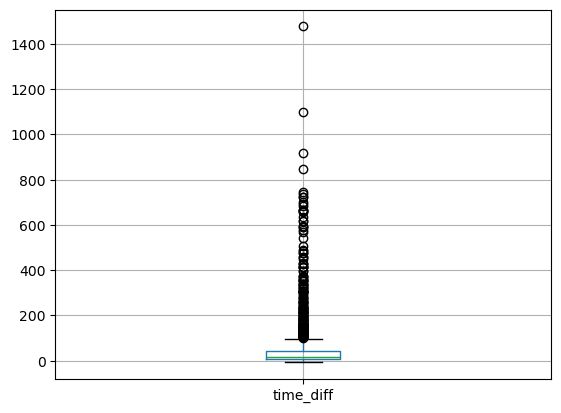

In [21]:
travel_type_1.boxplot('time_diff')
plt.show()

In [22]:
# Understanding outliers

Q1 = travel_type_1['time_diff'].quantile(0.25)
Q3 = travel_type_1['time_diff'].quantile(0.75)

IQR = Q3 - Q1

LL = Q1 - 1.5 * IQR
UL = Q3 + 1.5 * IQR

print(f"Q1: {Q1} | Q3: {Q3} | IQR: {IQR} | LL: {LL} | UL: {UL}")

outlier_count_ul = travel_type_1[travel_type_1['time_diff'] > UL].shape[0]
outlier_perc_ul = (outlier_count_ul * 100) / travel_type_1.shape[0]

outlier_count_ll = travel_type_1[travel_type_1['time_diff'] < LL].shape[0]
outlier_perc_ll = (outlier_count_ll * 100) / travel_type_1.shape[0]

print(f"# of Outliers on the Higher Side: {outlier_count_ul} | % of Outliers on the Higher Side: {outlier_perc_ul}%")
print(f"# of Outliers on the Lower Side: {outlier_count_ll} | % of Outliers on the Lower Side: {outlier_perc_ll}%")

# Since > 13% of the rows are outliers, we will create categories, rather than replacing with limits 

Q1: 9.05 | Q3: 44.55 | IQR: 35.5 | LL: -44.2 | UL: 97.8
# of Outliers on the Higher Side: 219 | % of Outliers on the Higher Side: 13.782252989301448%
# of Outliers on the Lower Side: 0 | % of Outliers on the Lower Side: 0.0%


In [23]:
# transform the time_diff into Urgent, SameDay, Regular, Advance bookings, since time_diff has >10% outliers

travel_type_1['booking_nature'] = pd.cut(travel_type_1['time_diff'], bins=[-8,2,17,45,1500],labels=['Urgent','SameDay','Regular','Advance'])

In [24]:
travel_type_1.drop(columns=['from_date','booking_created','from_hour','time_diff'], inplace=True)

In [25]:
travel_type_1.isnull().sum()

online_booking                      0
mobile_site_booking                 0
Car_Cancellation                    0
is_VMID_12                          0
from_area_car_cancellation_level    0
city_route_cancellation_level       0
from_month                          0
from_day_of_week                    0
from_is_weekend                     0
from_time_of_day                    0
booking_nature                      0
dtype: int64

In [26]:
# Renaming and dropping target column

travel_type_1['car_cancellation']=travel_type_1['Car_Cancellation']
travel_type_1. drop(columns=['Car_Cancellation'], inplace=True)

In [27]:
travel_type_1

,online_booking,mobile_site_booking,is_VMID_12,from_area_car_cancellation_level,city_route_cancellation_level,from_month,from_day_of_week,from_is_weekend,from_time_of_day,booking_nature,car_cancellation
6,0,0,1,low,low,1,1,0,Morning,Urgent,0
17,1,0,0,zero,low,1,5,1,Morning,Advance,0
24,0,0,0,zero,low,1,5,1,Morning,Advance,0
158,1,0,0,zero,zero,1,4,0,Morning,Regular,0
216,1,0,0,zero,low,1,6,1,Morning,Advance,0
...,...,...,...,...,...,...,...,...,...,...,...
43342,1,0,1,low,low,11,5,1,Evening,SameDay,0
43385,1,0,0,zero,low,11,4,0,Afternoon,Advance,0
43386,1,0,1,zero,low,11,6,1,Morning,SameDay,0
43393,0,0,1,low,zero,11,6,1,Morning,SameDay,0


In [28]:
travel_type_1 = travel_type_1[['from_area_car_cancellation_level','city_route_cancellation_level','from_time_of_day','booking_nature','online_booking', 'mobile_site_booking',
       'from_month', 'from_day_of_week',
       'from_is_weekend','is_VMID_12',
       'car_cancellation']].copy()

In [29]:
type_1 = travel_type_1.copy()

In [30]:
type_1

,from_area_car_cancellation_level,city_route_cancellation_level,from_time_of_day,booking_nature,online_booking,mobile_site_booking,from_month,from_day_of_week,from_is_weekend,is_VMID_12,car_cancellation
6,low,low,Morning,Urgent,0,0,1,1,0,1,0
17,zero,low,Morning,Advance,1,0,1,5,1,0,0
24,zero,low,Morning,Advance,0,0,1,5,1,0,0
158,zero,zero,Morning,Regular,1,0,1,4,0,0,0
216,zero,low,Morning,Advance,1,0,1,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
43342,low,low,Evening,SameDay,1,0,11,5,1,1,0
43385,zero,low,Afternoon,Advance,1,0,11,4,0,0,0
43386,zero,low,Morning,SameDay,1,0,11,6,1,1,0
43393,low,zero,Morning,SameDay,0,0,11,6,1,1,0


## EDA

In [31]:
import seaborn as sns

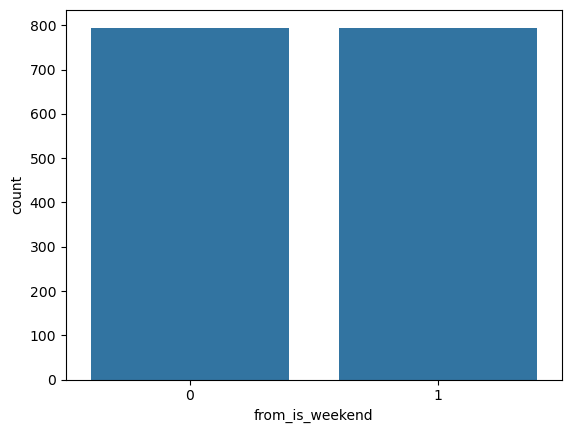

In [32]:
sns.countplot(x='from_is_weekend',data=type_1)
plt.show()

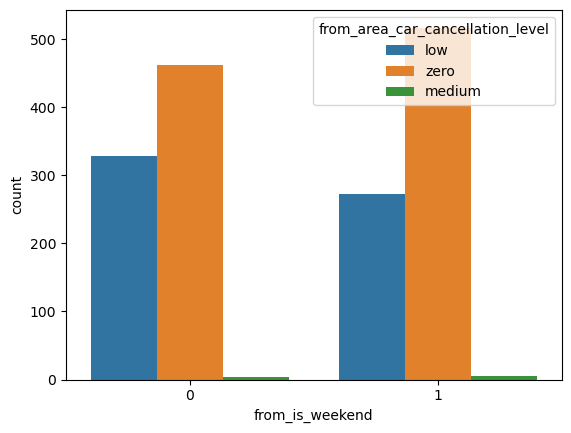

In [33]:
sns.countplot(x='from_is_weekend',hue='from_area_car_cancellation_level', data = type_1)
plt.show()

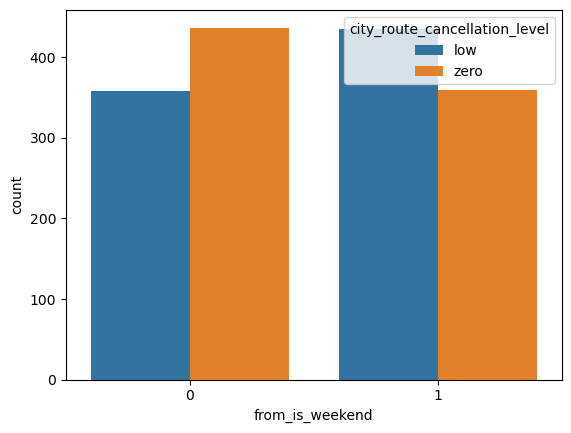

In [34]:
sns.countplot(x='from_is_weekend',hue='city_route_cancellation_level', data = type_1)
plt.show()

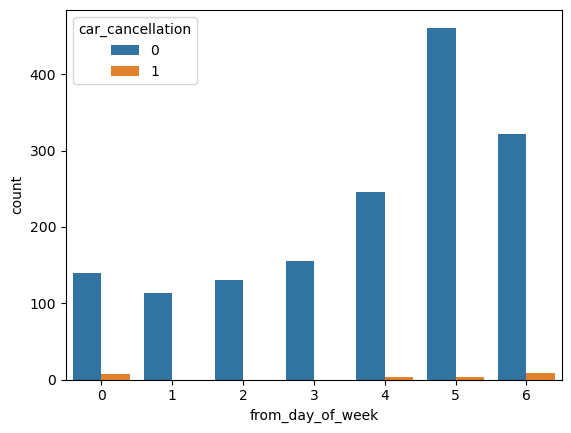

In [35]:
sns.countplot(x='from_day_of_week',hue='car_cancellation', data = type_1)
plt.show()

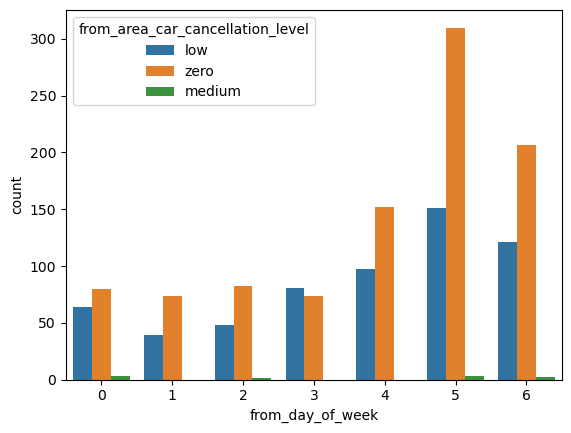

In [36]:
sns.countplot(x='from_day_of_week',hue='from_area_car_cancellation_level', data = type_1)
plt.show()

## Label Encoding since features are of ordinal type

In [37]:
type_1

,from_area_car_cancellation_level,city_route_cancellation_level,from_time_of_day,booking_nature,online_booking,mobile_site_booking,from_month,from_day_of_week,from_is_weekend,is_VMID_12,car_cancellation
6,low,low,Morning,Urgent,0,0,1,1,0,1,0
17,zero,low,Morning,Advance,1,0,1,5,1,0,0
24,zero,low,Morning,Advance,0,0,1,5,1,0,0
158,zero,zero,Morning,Regular,1,0,1,4,0,0,0
216,zero,low,Morning,Advance,1,0,1,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
43342,low,low,Evening,SameDay,1,0,11,5,1,1,0
43385,zero,low,Afternoon,Advance,1,0,11,4,0,0,0
43386,zero,low,Morning,SameDay,1,0,11,6,1,1,0
43393,low,zero,Morning,SameDay,0,0,11,6,1,1,0


In [38]:
# Label Encoding
type_1.from_area_car_cancellation_level = type_1.from_area_car_cancellation_level.map({"zero":1,"low":2,"medium":3,"high":4})
type_1.city_route_cancellation_level = type_1.city_route_cancellation_level.map({"zero":1,"low":2,"medium":3,"high":4})
type_1.booking_nature = type_1.booking_nature.map({"Urgent":1,"SameDay":2,"Regular":3,"Advance":4})
type_1.from_time_of_day = type_1.from_time_of_day.map({"Morning":1,"Afternoon":2,"Evening":3,"Night":4})

In [39]:
type_1

,from_area_car_cancellation_level,city_route_cancellation_level,from_time_of_day,booking_nature,online_booking,mobile_site_booking,from_month,from_day_of_week,from_is_weekend,is_VMID_12,car_cancellation
6,2,2,1,1,0,0,1,1,0,1,0
17,1,2,1,4,1,0,1,5,1,0,0
24,1,2,1,4,0,0,1,5,1,0,0
158,1,1,1,3,1,0,1,4,0,0,0
216,1,2,1,4,1,0,1,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
43342,2,2,3,2,1,0,11,5,1,1,0
43385,1,2,2,4,1,0,11,4,0,0,0
43386,1,2,1,2,1,0,11,6,1,1,0
43393,2,1,1,2,0,0,11,6,1,1,0


In [40]:
#Checking feature importance if the p value is greater than 0.05 then it should be dropped.
from scipy.stats import chi2_contingency

ct = pd.crosstab(type_1['from_day_of_week'], type_1['car_cancellation'])
chi2, p, _, _ = chi2_contingency(ct)
print("p-value:", p)

p-value: 0.0006704659780930822


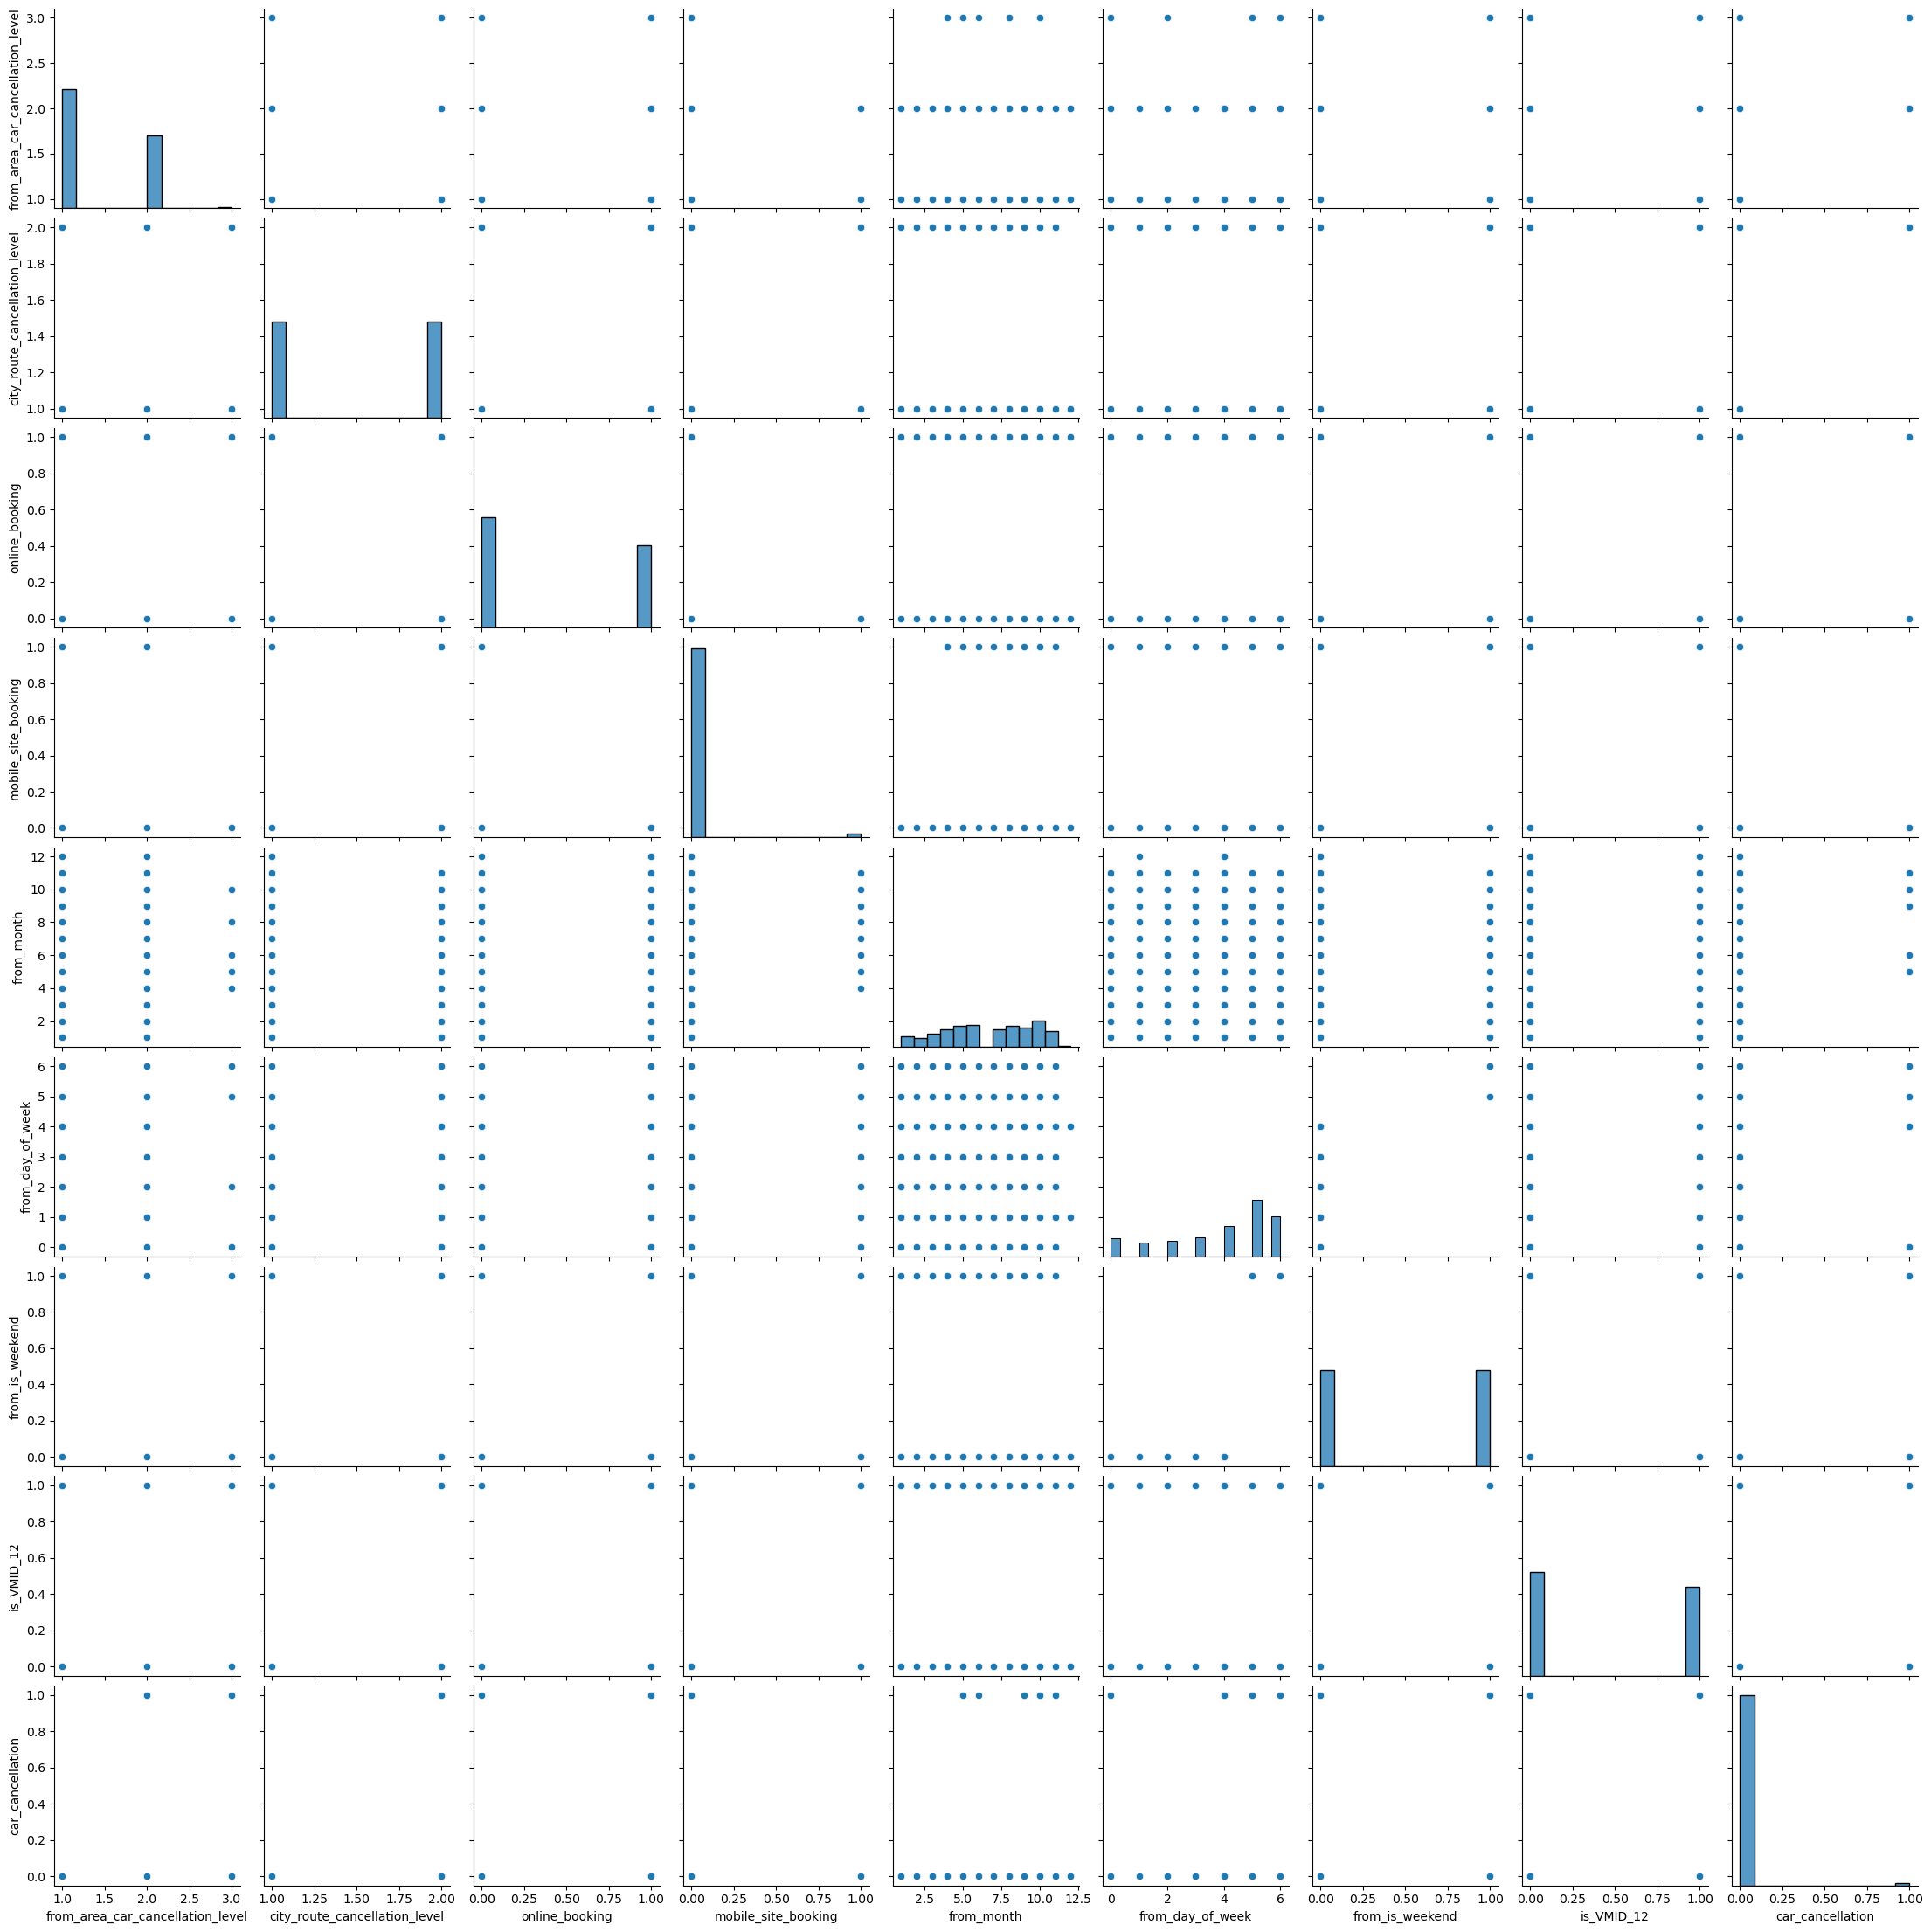

In [41]:
sns.pairplot(data=type_1)
plt.show()

##### Since it can be clearly seen that most of the features are not linearly separable so linear models will perform badly on these features so we will go ahead with different algorithms 

## Algorithms

#### Decision Tree Algorithm

In [42]:
x_train,x_test,y_train,y_test = train_test_split(type_1.drop(columns=['car_cancellation'],axis=1), type_1['car_cancellation'],test_size=0.2, random_state=20)

In [43]:
# Simple DT model without any hyperparameters tunning
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

In [44]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [45]:
ytrainpred = dt.predict(x_train)
ytestpred = dt.predict(x_test)

In [46]:
from sklearn.metrics import classification_report

In [47]:
y_train.value_counts()

car_cancellation
0    1253
1      18
Name: count, dtype: int64

In [48]:
print(classification_report(ytrainpred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1256
           1       0.83      1.00      0.91        15

    accuracy                           1.00      1271
   macro avg       0.92      1.00      0.95      1271
weighted avg       1.00      1.00      1.00      1271



In [49]:
y_test.value_counts()

car_cancellation
0    315
1      3
Name: count, dtype: int64

In [50]:
print(classification_report(ytestpred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       311
           1       0.33      0.14      0.20         7

    accuracy                           0.97       318
   macro avg       0.66      0.57      0.59       318
weighted avg       0.97      0.97      0.97       318



#### Using optuna as Hyperparameter tunning

In [51]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    
    # Model
    model = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Cross-validation score
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    return np.mean(scores)


In [52]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # You can increase trials for better results

[I 2025-09-06 12:53:22,380] A new study created in memory with name: no-name-ea7b5d46-8259-4651-bc40-965addeb21f6
[I 2025-09-06 12:53:22,389] Trial 0 finished with value: 0.9842643199011889 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.9842643199011889.
[I 2025-09-06 12:53:22,397] Trial 1 finished with value: 0.9858391230507951 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.9858391230507951.
[I 2025-09-06 12:53:22,404] Trial 2 finished with value: 0.9858391230507951 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 1 with value: 0.9858391230507951.
[I 2025-09-06 12:53:22,411] Trial 3 finished with value:

In [53]:
study.best_params

{'criterion': 'entropy',
 'splitter': 'best',
 'max_depth': 16,
 'min_samples_split': 18,
 'min_samples_leaf': 2,
 'max_features': None}

In [54]:
best_model = DecisionTreeClassifier(
    **study.best_params,
    random_state=42
)
best_model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=2,
                       min_samples_split=18, random_state=42)

In [55]:
ytrainpred_best = best_model.predict(x_train)
ytestpred_best = best_model.predict(x_test)

In [56]:
y_train.value_counts()

car_cancellation
0    1253
1      18
Name: count, dtype: int64

In [57]:
print(classification_report(ytrainpred_best, y_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1261
           1       0.44      0.80      0.57        10

    accuracy                           0.99      1271
   macro avg       0.72      0.90      0.78      1271
weighted avg       0.99      0.99      0.99      1271



In [58]:
y_test.value_counts()

car_cancellation
0    315
1      3
Name: count, dtype: int64

In [59]:
print(classification_report(ytestpred_best, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       316
           1       0.33      0.50      0.40         2

    accuracy                           0.99       318
   macro avg       0.67      0.75      0.70       318
weighted avg       0.99      0.99      0.99       318



#### Both models have ~99% accuracy — but that’s misleading due to class imbalance 
#### We need to treat this dataset again in a separate notebook



### Ensemble model

In [60]:
y_train.value_counts()

car_cancellation
0    1253
1      18
Name: count, dtype: int64

In [61]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Define base models
clf_dt = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
clf_svc = SVC(probability=True, random_state=42)  # probability=True for soft voting

# Step 2: Create Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('decision_tree', clf_dt),
        ('random_forest', clf_rf),
        ('svm', clf_svc)
    ],
    voting='hard'  # use 'hard' if you don’t want to use probabilities
)

# Step 3: Train on training set
ensemble_model.fit(x_train, y_train)

# Step 4: Predict
ytrainpred_ens = ensemble_model.predict(x_train)
ytestpred_ens = ensemble_model.predict(x_test)

# Step 5: Evaluate
print("Train Report:\n", classification_report(y_train, ytrainpred_ens))
print("Test Report:\n", classification_report(y_test, ytestpred_ens))


Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1253
           1       1.00      0.83      0.91        18

    accuracy                           1.00      1271
   macro avg       1.00      0.92      0.95      1271
weighted avg       1.00      1.00      1.00      1271

Test Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       315
           1       0.50      0.33      0.40         3

    accuracy                           0.99       318
   macro avg       0.75      0.67      0.70       318
weighted avg       0.99      0.99      0.99       318



In [62]:
# Stacking approach

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Define base models (level-0)
base_models = [
    ('dt', DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('svc', SVC(class_weight='balanced', probability=True, random_state=42))  # probability=True required for stacking
]

# Step 2: Define meta-model (level-1)
meta_model = LogisticRegression()

# Step 3: Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # cross-validation for level-1 training
)

# Step 4: Fit on training data
stacking_model.fit(x_train, y_train)

# Step 5: Predict
ytrainpred_stack = stacking_model.predict(x_train)
ytestpred_stack = stacking_model.predict(x_test)

# Step 6: Evaluate
print("Train Report:\n", classification_report(y_train, ytrainpred_stack))
print("Test Report:\n", classification_report(y_test, ytestpred_stack))


Train Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1253
           1       1.00      0.11      0.20        18

    accuracy                           0.99      1271
   macro avg       0.99      0.56      0.60      1271
weighted avg       0.99      0.99      0.98      1271

Test Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       315
           1       0.00      0.00      0.00         3

    accuracy                           0.99       318
   macro avg       0.50      0.50      0.50       318
weighted avg       0.98      0.99      0.99       318



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Deploy the Stacking Model with class_weight='balanced'
#### Because:

#### You retain precision (1.00) on class 1 (zero false positives)

#### Recall is same as other models (0.33) but more generalizable

#### F1-score is highest (0.50) — best harmonic balance

#### Lower risk of overfitting (vs tuned DT which was fitted tightly to training)

## For Travel Type 2

In [63]:
keep_copy = travel_type_2.copy()

In [64]:

travel_type_2 = keep_copy.copy()

In [65]:

travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   34292 non-null  int64  
 1   user_id              34292 non-null  int64  
 2   vehicle_model_id     34292 non-null  int64  
 3   package_id           0 non-null      float64
 4   travel_type_id       34292 non-null  int64  
 5   from_area_id         34292 non-null  float64
 6   to_area_id           34292 non-null  float64
 7   from_city_id         14504 non-null  float64
 8   to_city_id           0 non-null      float64
 9   from_date            34292 non-null  object 
 10  online_booking       34292 non-null  int64  
 11  mobile_site_booking  34292 non-null  int64  
 12  booking_created      34292 non-null  object 
 13  from_lat             34292 non-null  float64
 14  from_long            34292 non-null  float64
 15  to_lat               34292 non-null  floa

In [66]:
travel_type_2.drop(columns=['package_id','id','travel_type_id','user_id','vehicle_model_id', 'from_city_id','to_city_id'], inplace=True)

In [67]:
travel_type_2.isnull().sum()

from_area_id           0
to_area_id             0
from_date              0
online_booking         0
mobile_site_booking    0
booking_created        0
from_lat               0
from_long              0
to_lat                 0
to_long                0
Car_Cancellation       0
is_VMID_12             0
dtype: int64

#### Since there are no missing values then no treatment is needed

In [68]:
#Creating a route between from_city and to_city to identify the cancellation volume later on based on the routes

travel_type_2['area_route'] = travel_type_2['from_area_id'].astype(str)+'-'+travel_type_2['to_area_id'].astype(str)  

In [69]:
# Calculating cancellation level for each route

travel_type_2['city_route_cancellation_level'] = travel_type_2.groupby('area_route')['Car_Cancellation'].transform(calc_cancellation_level_for_group)

In [70]:
travel_type_2['city_route_cancellation_level'].value_counts()

city_route_cancellation_level
zero      20786
low       10799
medium     1410
high       1297
Name: count, dtype: int64

In [71]:
travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   from_area_id                   34292 non-null  float64
 1   to_area_id                     34292 non-null  float64
 2   from_date                      34292 non-null  object 
 3   online_booking                 34292 non-null  int64  
 4   mobile_site_booking            34292 non-null  int64  
 5   booking_created                34292 non-null  object 
 6   from_lat                       34292 non-null  float64
 7   from_long                      34292 non-null  float64
 8   to_lat                         34292 non-null  float64
 9   to_long                        34292 non-null  float64
 10  Car_Cancellation               34292 non-null  int64  
 11  is_VMID_12                     34292 non-null  int64  
 12  area_route                     34292 non-null  obje

In [72]:
travel_type_2.drop(columns=['from_area_id','to_area_id','area_route'], inplace=True)

In [73]:
travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   from_date                      34292 non-null  object 
 1   online_booking                 34292 non-null  int64  
 2   mobile_site_booking            34292 non-null  int64  
 3   booking_created                34292 non-null  object 
 4   from_lat                       34292 non-null  float64
 5   from_long                      34292 non-null  float64
 6   to_lat                         34292 non-null  float64
 7   to_long                        34292 non-null  float64
 8   Car_Cancellation               34292 non-null  int64  
 9   is_VMID_12                     34292 non-null  int64  
 10  city_route_cancellation_level  34292 non-null  object 
dtypes: float64(4), int64(4), object(3)
memory usage: 3.1+ MB


In [74]:
# Converting string columns to datetime to extract necessary attributes

travel_type_2['from_date'] = pd.to_datetime(travel_type_2['from_date'], format='mixed')
travel_type_2['booking_created'] = pd.to_datetime(travel_type_2['booking_created'], format='mixed')

# Extracting month

travel_type_2['from_month'] = travel_type_2['from_date'].dt.month

# Extracting day of week in numerical format

travel_type_2['from_day_of_week'] = travel_type_2['from_date'].dt.dayofweek
travel_type_2['from_is_weekend']=np.where(travel_type_2['from_day_of_week'] >= 5,1,0)
# Deriving the columns to understand the cancellation volume as per the time of day

travel_type_2['from_hour']=travel_type_2['from_date'].dt.hour
travel_type_2['from_time_of_day'] = pd.cut(travel_type_2['from_hour'], bins=[-1,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])

# calculate the number of hours b/w booking and actual start time in hours

travel_type_2['time_diff'] = (travel_type_2.from_date - travel_type_2.booking_created).dt.total_seconds()/3600


In [75]:
travel_type_2.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   from_date                      34292 non-null  datetime64[ns]
 1   online_booking                 34292 non-null  int64         
 2   mobile_site_booking            34292 non-null  int64         
 3   booking_created                34292 non-null  datetime64[ns]
 4   from_lat                       34292 non-null  float64       
 5   from_long                      34292 non-null  float64       
 6   to_lat                         34292 non-null  float64       
 7   to_long                        34292 non-null  float64       
 8   Car_Cancellation               34292 non-null  int64         
 9   is_VMID_12                     34292 non-null  int64         
 10  city_route_cancellation_level  34292 non-null  object        
 11  from_month          

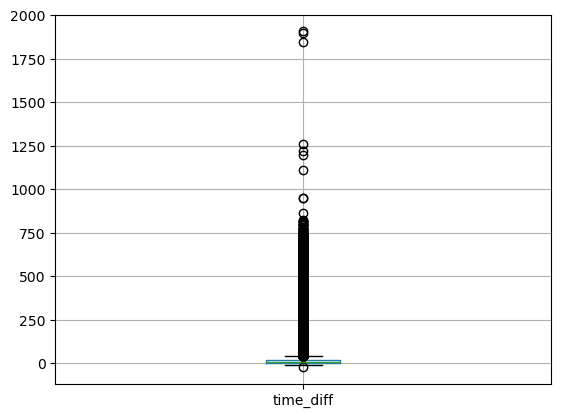

In [76]:
travel_type_2.boxplot('time_diff')
plt.show()

In [77]:
Q1 = travel_type_2['time_diff'].quantile(0.25)
Q3 = travel_type_2['time_diff'].quantile(0.75)

IQR = Q3 - Q1

LL = Q1 - 1.5 * IQR
UL = Q3 + 1.5 * IQR

print(f"Q1: {Q1} | Q3: {Q3} | IQR: {IQR} | LL: {LL} | UL: {UL}")

outlier_count_ul = travel_type_2[travel_type_2['time_diff'] > UL].shape[0]
outlier_perc_ul = (outlier_count_ul * 100) / travel_type_2.shape[0]

outlier_count_ll = travel_type_2[travel_type_2['time_diff'] < LL].shape[0]
outlier_perc_ll = (outlier_count_ll * 100) / travel_type_2.shape[0]

print(f"# of Outliers on the Higher Side: {outlier_count_ul} | % of Outliers on the Higher Side: {outlier_perc_ul}%")
print(f"# of Outliers on the Lower Side: {outlier_count_ll} | % of Outliers on the Lower Side: {outlier_perc_ll}%")


Q1: 3.183333333333333 | Q3: 19.166666666666668 | IQR: 15.983333333333334 | LL: -20.791666666666668 | UL: 43.141666666666666
# of Outliers on the Higher Side: 4612 | % of Outliers on the Higher Side: 13.449200979820366%
# of Outliers on the Lower Side: 1 | % of Outliers on the Lower Side: 0.0029161320424588824%


#### Since > 13% of the rows are outliers, we will create categories, rather than replacing with limits 

In [78]:
# This understanding is important for creating bins
travel_type_2['time_diff'].describe()

count    34292.000000
mean        37.202130
std        100.917727
min        -22.900000
25%          3.183333
50%          8.833333
75%         19.166667
max       1906.900000
Name: time_diff, dtype: float64

In [79]:
# transform the time_diff into Urgent, SameDay, Regular, Advance bookings, since time_diff has >10% outliers

travel_type_2['booking_nature'] = pd.cut(travel_type_2['time_diff'], bins=[-23,3.2,9,20,1910],labels=['Urgent','SameDay','Regular','Advance'])

In [80]:
travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   from_date                      34292 non-null  datetime64[ns]
 1   online_booking                 34292 non-null  int64         
 2   mobile_site_booking            34292 non-null  int64         
 3   booking_created                34292 non-null  datetime64[ns]
 4   from_lat                       34292 non-null  float64       
 5   from_long                      34292 non-null  float64       
 6   to_lat                         34292 non-null  float64       
 7   to_long                        34292 non-null  float64       
 8   Car_Cancellation               34292 non-null  int64         
 9   is_VMID_12                     34292 non-null  int64         
 10  city_route_cancellation_level  34292 non-null  object        
 11  from_month          

In [81]:
travel_type_2.drop(columns=['from_date','booking_created','from_hour','time_diff'],inplace=True)

In [82]:
travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   online_booking                 34292 non-null  int64   
 1   mobile_site_booking            34292 non-null  int64   
 2   from_lat                       34292 non-null  float64 
 3   from_long                      34292 non-null  float64 
 4   to_lat                         34292 non-null  float64 
 5   to_long                        34292 non-null  float64 
 6   Car_Cancellation               34292 non-null  int64   
 7   is_VMID_12                     34292 non-null  int64   
 8   city_route_cancellation_level  34292 non-null  object  
 9   from_month                     34292 non-null  int32   
 10  from_day_of_week               34292 non-null  int32   
 11  from_is_weekend                34292 non-null  int64   
 12  from_time_of_day               34292 

In [83]:
from geopy.distance import geodesic

In [84]:
def calc_distance(row):
    from_cord = (row['from_lat'],row['from_long'])  #pickup point
    to_cord = (row['to_lat'],row['to_long'])  # drop point
    return geodesic(from_cord,to_cord).kilometers

In [85]:
travel_type_2['distance'] =  travel_type_2.apply(calc_distance,axis=1)

In [86]:
travel_type_2.drop(columns=['from_lat','from_long','to_lat','to_long'],inplace=True)

In [87]:
travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   online_booking                 34292 non-null  int64   
 1   mobile_site_booking            34292 non-null  int64   
 2   Car_Cancellation               34292 non-null  int64   
 3   is_VMID_12                     34292 non-null  int64   
 4   city_route_cancellation_level  34292 non-null  object  
 5   from_month                     34292 non-null  int32   
 6   from_day_of_week               34292 non-null  int32   
 7   from_is_weekend                34292 non-null  int64   
 8   from_time_of_day               34292 non-null  category
 9   booking_nature                 34292 non-null  category
 10  distance                       34292 non-null  float64 
dtypes: category(2), float64(1), int32(2), int64(5), object(1)
memory usage: 2.4+ MB


In [88]:
travel_type_2 = travel_type_2[['city_route_cancellation_level','booking_nature','from_time_of_day','from_is_weekend','from_day_of_week','from_month','is_VMID_12','online_booking','mobile_site_booking','distance','Car_Cancellation']]

In [89]:
travel_type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34292 entries, 0 to 43430
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   city_route_cancellation_level  34292 non-null  object  
 1   booking_nature                 34292 non-null  category
 2   from_time_of_day               34292 non-null  category
 3   from_is_weekend                34292 non-null  int64   
 4   from_day_of_week               34292 non-null  int32   
 5   from_month                     34292 non-null  int32   
 6   is_VMID_12                     34292 non-null  int64   
 7   online_booking                 34292 non-null  int64   
 8   mobile_site_booking            34292 non-null  int64   
 9   distance                       34292 non-null  float64 
 10  Car_Cancellation               34292 non-null  int64   
dtypes: category(2), float64(1), int32(2), int64(5), object(1)
memory usage: 2.4+ MB


### EDA

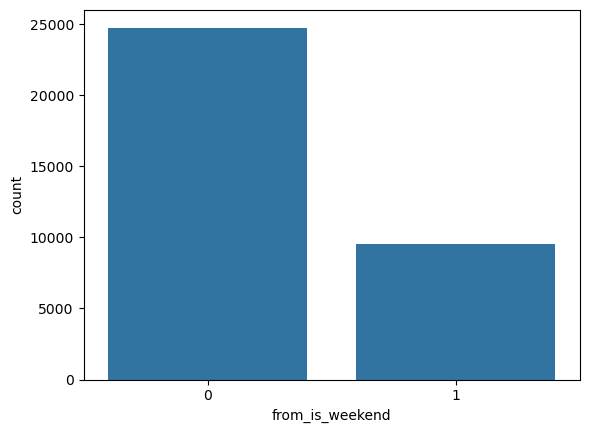

In [90]:
sns.countplot(x='from_is_weekend',data=travel_type_2)  # booking volume on a weekday and weekend
plt.show()

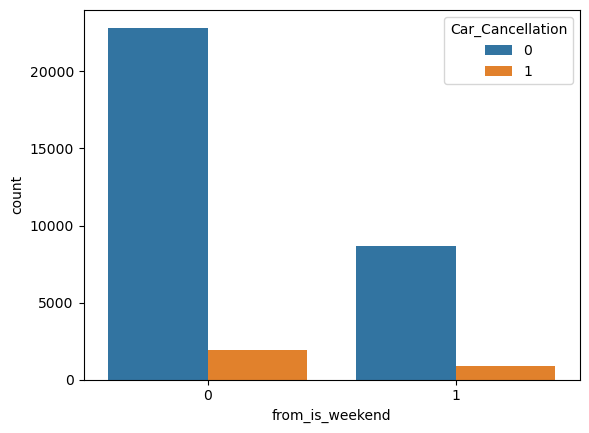

In [91]:
sns.countplot(x='from_is_weekend',hue='Car_Cancellation',data=travel_type_2)
plt.show()

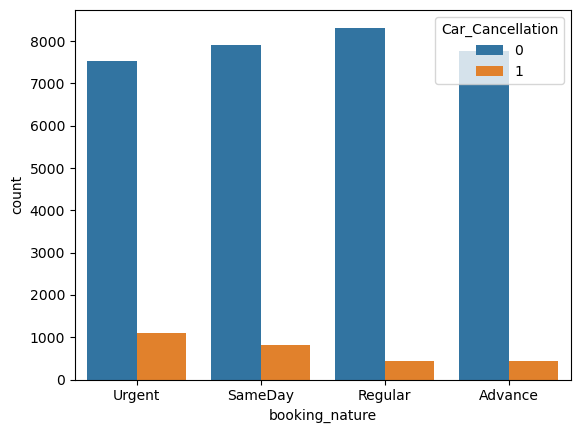

In [92]:
sns.countplot(x='booking_nature',hue='Car_Cancellation',data=travel_type_2)
plt.show()

#### Label Encoders

In [93]:
travel_type_2.city_route_cancellation_level = travel_type_2.city_route_cancellation_level.str.strip().str.lower().map({"zero":1,"low":2,"medium":3,"high":4})
travel_type_2.booking_nature = travel_type_2.booking_nature.map({"Urgent":1,"SameDay":2,"Regular":3,"Advance":4})
travel_type_2.from_time_of_day = travel_type_2.from_time_of_day.map({"Morning":1,"Afternoon":2,"Evening":3,"Night":4})
travel_type_2

,city_route_cancellation_level,booking_nature,from_time_of_day,from_is_weekend,from_day_of_week,from_month,is_VMID_12,online_booking,mobile_site_booking,distance,Car_Cancellation
0,1,1,4,0,1,1,0,0,0,3.980687,0
1,1,2,1,0,1,1,1,0,0,14.004432,0
2,1,1,4,0,1,1,1,0,0,12.648909,0
3,1,1,4,0,1,1,1,0,0,9.534596,0
4,1,1,1,0,1,1,1,0,0,14.655467,0
...,...,...,...,...,...,...,...,...,...,...,...
43425,1,3,4,0,0,11,1,0,1,12.180435,0
43426,1,2,2,1,6,11,1,1,0,10.681284,0
43427,1,4,4,0,1,11,1,1,0,21.251031,0
43429,1,1,2,1,6,11,0,0,0,4.584142,0


### Machine Learning

In [94]:
X = travel_type_2.drop('Car_Cancellation',axis=1)
Y = travel_type_2['Car_Cancellation']

In [95]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.2)

In [96]:
ytrain.value_counts()

Car_Cancellation
0    25209
1     2224
Name: count, dtype: int64

In [97]:
ytest.value_counts()

Car_Cancellation
0    6308
1     551
Name: count, dtype: int64

### Stacking Classifier

In [98]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Define base models (level-0)
base_models = [
    ('dt', DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('svc', SVC(class_weight='balanced', probability=True, random_state=42))  # probability=True required for stacking
]

# Step 2: Define meta-model (level-1)
meta_model = LogisticRegression()

# Step 3: Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # cross-validation for level-1 training
)

# Step 4: Fit on training data
stacking_model.fit(xtrain, ytrain)

# Step 5: Predict
ytrainpred_stack = stacking_model.predict(xtrain)
ytestpred_stack = stacking_model.predict(xtest)

# Step 6: Evaluate
print("Train Report:\n", classification_report(ytrain, ytrainpred_stack))
print("Test Report:\n", classification_report(ytest, ytestpred_stack))

Train Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     25209
           1       0.95      0.84      0.89      2224

    accuracy                           0.98     27433
   macro avg       0.97      0.92      0.94     27433
weighted avg       0.98      0.98      0.98     27433

Test Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      6308
           1       0.83      0.61      0.70       551

    accuracy                           0.96      6859
   macro avg       0.90      0.80      0.84      6859
weighted avg       0.96      0.96      0.96      6859



### Voting classifier

In [99]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Define base models
clf_dt = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
clf_svc = SVC(probability=True, random_state=42)  # probability=True for soft voting

# Step 2: Create Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('decision_tree', clf_dt),
        ('random_forest', clf_rf),
        ('svm', clf_svc)
    ],
    voting='hard'  # use 'hard' if you don’t want to use probabilities
)

# Step 3: Train on training set
ensemble_model.fit(xtrain, ytrain)

# Step 4: Predict
ytrainpred_ens = ensemble_model.predict(xtrain)
ytestpred_ens = ensemble_model.predict(xtest)

# Step 5: Evaluate
print("Train Report:\n", classification_report(ytrain, ytrainpred_ens))
print("Test Report:\n", classification_report(ytest, ytestpred_ens))


Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25209
           1       0.99      0.97      0.98      2224

    accuracy                           1.00     27433
   macro avg       0.99      0.98      0.99     27433
weighted avg       1.00      1.00      1.00     27433

Test Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      6308
           1       0.80      0.61      0.69       551

    accuracy                           0.96      6859
   macro avg       0.88      0.80      0.83      6859
weighted avg       0.95      0.96      0.95      6859



### RandomForest Algorithm

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
rf = RandomForestClassifier()

In [102]:
rf.fit(xtrain, ytrain)

RandomForestClassifier()

In [103]:
ytest_pred = rf.predict(xtest)
ytrain_pred = rf.predict(xtrain)

In [104]:
print("Train Report:\n", classification_report(ytrain, ytrain_pred))
print("Test Report:\n", classification_report(ytest, ytest_pred))

Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25209
           1       0.98      0.97      0.98      2224

    accuracy                           1.00     27433
   macro avg       0.99      0.99      0.99     27433
weighted avg       1.00      1.00      1.00     27433

Test Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      6308
           1       0.79      0.63      0.70       551

    accuracy                           0.96      6859
   macro avg       0.88      0.81      0.84      6859
weighted avg       0.95      0.96      0.95      6859



#### Since all 3 models are performing well on both training and test data then we can go ahead with either of these models

### Travel_Type_3:  Model

In [105]:
copy_travel_type_3 = travel_type_3.copy()

In [106]:
travel_type_3 = copy_travel_type_3.copy()

In [107]:
travel_type_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7550 entries, 8 to 43428
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7550 non-null   int64  
 1   user_id              7550 non-null   int64  
 2   vehicle_model_id     7550 non-null   int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       7550 non-null   int64  
 5   from_area_id         7550 non-null   float64
 6   to_area_id           0 non-null      float64
 7   from_city_id         448 non-null    float64
 8   to_city_id           0 non-null      float64
 9   from_date            7550 non-null   object 
 10  online_booking       7550 non-null   int64  
 11  mobile_site_booking  7550 non-null   int64  
 12  booking_created      7550 non-null   object 
 13  from_lat             7550 non-null   float64
 14  from_long            7550 non-null   float64
 15  to_lat               0 non-null      float

In [108]:
travel_type_3['from_area_car_cancellation_level'] = (
    travel_type_3
    .groupby('from_area_id')['Car_Cancellation']
    .transform(calc_cancellation_level_for_group)
)

In [109]:
travel_type_3.drop(columns=['id','user_id','travel_type_id','from_area_id','to_area_id','from_city_id','to_city_id','from_long','from_lat','to_long','to_lat'], inplace=True)

In [110]:
travel_type_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7550 entries, 8 to 43428
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   vehicle_model_id                  7550 non-null   int64  
 1   package_id                        7550 non-null   float64
 2   from_date                         7550 non-null   object 
 3   online_booking                    7550 non-null   int64  
 4   mobile_site_booking               7550 non-null   int64  
 5   booking_created                   7550 non-null   object 
 6   Car_Cancellation                  7550 non-null   int64  
 7   is_VMID_12                        7550 non-null   int64  
 8   from_area_car_cancellation_level  7550 non-null   object 
dtypes: float64(1), int64(5), object(3)
memory usage: 589.8+ KB


In [111]:
# Converting string columns to datetime to extract necessary attributes

travel_type_3['from_date'] = pd.to_datetime(travel_type_3['from_date'], format='mixed')
travel_type_3['booking_created'] = pd.to_datetime(travel_type_3['booking_created'], format='mixed')

# Extracting month

travel_type_3['from_month'] = travel_type_3['from_date'].dt.month

# Extracting day of week in numerical format

travel_type_3['from_day_of_week'] = travel_type_3['from_date'].dt.dayofweek
travel_type_3['from_is_weekend']=np.where(travel_type_3['from_day_of_week'] >= 5,1,0)
# Deriving the columns to understand the cancellation volume as per the time of day

travel_type_3['from_hour']=travel_type_3['from_date'].dt.hour
travel_type_3['from_time_of_day'] = pd.cut(travel_type_3['from_hour'], bins=[-1,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])

# calculate the number of hours b/w booking and actual start time in hours

travel_type_3['time_diff'] = (travel_type_3.from_date - travel_type_3.booking_created).dt.total_seconds()/3600


In [112]:
travel_type_3.drop(columns=['from_date','vehicle_model_id'], inplace=True)

In [113]:
travel_type_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7550 entries, 8 to 43428
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   package_id                        7550 non-null   float64       
 1   online_booking                    7550 non-null   int64         
 2   mobile_site_booking               7550 non-null   int64         
 3   booking_created                   7550 non-null   datetime64[ns]
 4   Car_Cancellation                  7550 non-null   int64         
 5   is_VMID_12                        7550 non-null   int64         
 6   from_area_car_cancellation_level  7550 non-null   object        
 7   from_month                        7550 non-null   int32         
 8   from_day_of_week                  7550 non-null   int32         
 9   from_is_weekend                   7550 non-null   int64         
 10  from_hour                         7550 non-null   in

In [114]:
Q1 = travel_type_3['time_diff'].quantile(0.25)
Q3 = travel_type_3['time_diff'].quantile(0.75)

IQR = Q3 - Q1

LL = Q1 - 1.5 * IQR
UL = Q3 + 1.5 * IQR

print(f"Q1: {Q1} | Q3: {Q3} | IQR: {IQR} | LL: {LL} | UL: {UL}")

outlier_count_ul = travel_type_3[travel_type_3['time_diff'] > UL].shape[0]
outlier_perc_ul = (outlier_count_ul * 100) / travel_type_3.shape[0]

outlier_count_ll = travel_type_3[travel_type_3['time_diff'] < LL].shape[0]
outlier_perc_ll = (outlier_count_ll * 100) / travel_type_3.shape[0]

print(f"# of Outliers on the Higher Side: {outlier_count_ul} | % of Outliers on the Higher Side: {outlier_perc_ul}%")
print(f"# of Outliers on the Lower Side: {outlier_count_ll} | % of Outliers on the Lower Side: {outlier_perc_ll}%")

Q1: 1.9208333333333334 | Q3: 13.766666666666667 | IQR: 11.845833333333335 | LL: -15.84791666666667 | UL: 31.53541666666667
# of Outliers on the Higher Side: 612 | % of Outliers on the Higher Side: 8.105960264900663%
# of Outliers on the Lower Side: 0 | % of Outliers on the Lower Side: 0.0%


In [115]:
travel_type_3['time_diff'].describe()

count    7550.000000
mean       14.570344
std        39.198073
min        -3.550000
25%         1.920833
50%         5.858333
75%        13.766667
max       695.550000
Name: time_diff, dtype: float64

In [116]:
# transform the time_diff into Urgent, SameDay, Regular, Advance bookings, since time_diff has >10% outliers

travel_type_3['booking_nature'] = pd.cut(travel_type_3['time_diff'], bins=[-23,3.2,9,20,1910],labels=['Urgent','SameDay','Regular','Advance'])

In [117]:
travel_type_3.drop(columns=['booking_created'], inplace=True)

In [118]:
travel_type_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7550 entries, 8 to 43428
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   package_id                        7550 non-null   float64 
 1   online_booking                    7550 non-null   int64   
 2   mobile_site_booking               7550 non-null   int64   
 3   Car_Cancellation                  7550 non-null   int64   
 4   is_VMID_12                        7550 non-null   int64   
 5   from_area_car_cancellation_level  7550 non-null   object  
 6   from_month                        7550 non-null   int32   
 7   from_day_of_week                  7550 non-null   int32   
 8   from_is_weekend                   7550 non-null   int64   
 9   from_hour                         7550 non-null   int32   
 10  from_time_of_day                  7550 non-null   category
 11  time_diff                         7550 non-null   float64 
 

### EDA

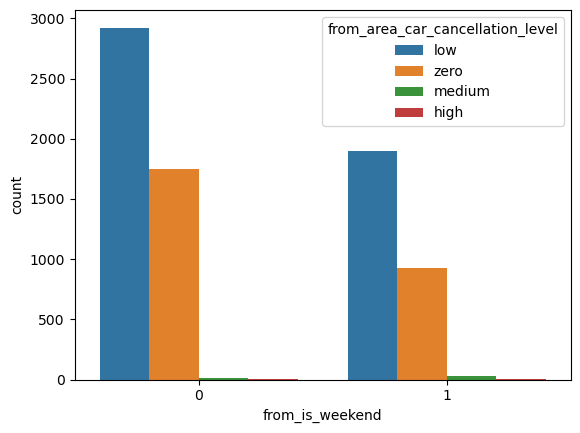

In [119]:
sns.countplot(x='from_is_weekend', hue='from_area_car_cancellation_level',data=travel_type_3)
plt.show()

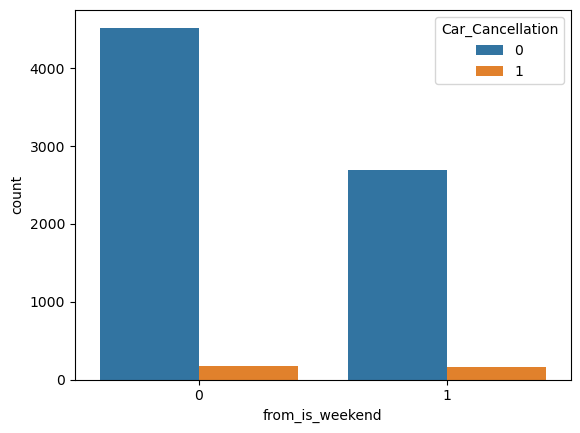

In [120]:
sns.countplot(x='from_is_weekend', hue='Car_Cancellation',data=travel_type_3)
plt.show()

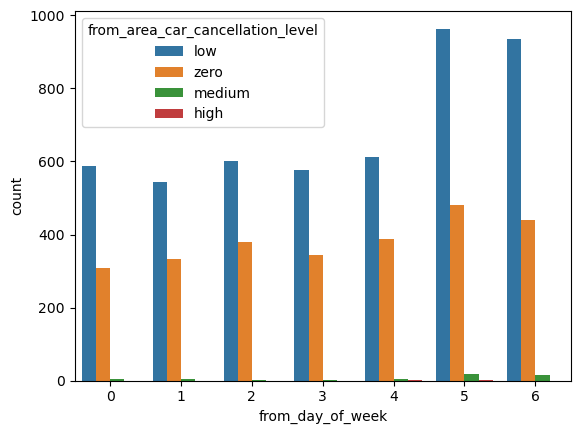

In [121]:
sns.countplot(x='from_day_of_week', hue='from_area_car_cancellation_level',data=travel_type_3)
plt.show()

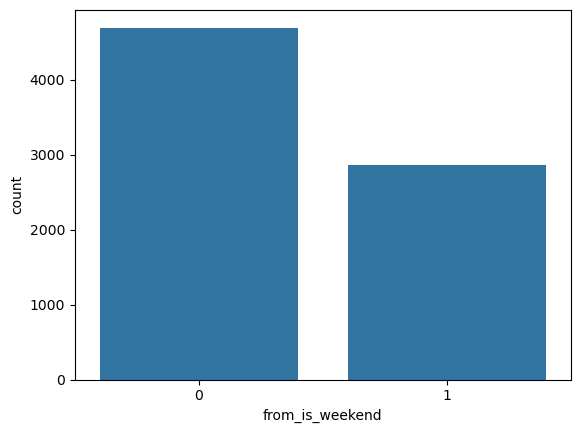

In [122]:
sns.countplot(x='from_is_weekend',data=travel_type_3)  # booking volume on a weekday and weekend
plt.show()

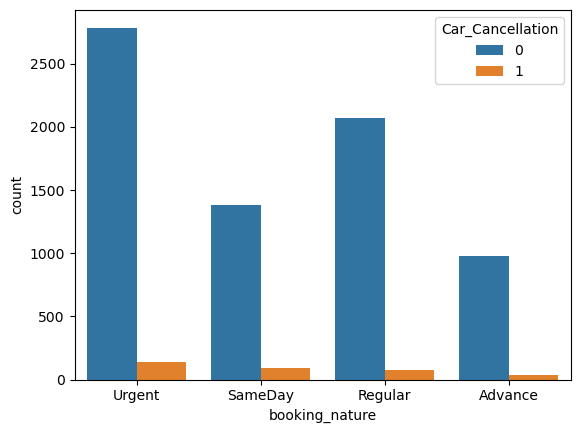

In [123]:
sns.countplot(x='booking_nature',hue='Car_Cancellation',data=travel_type_3)
plt.show()

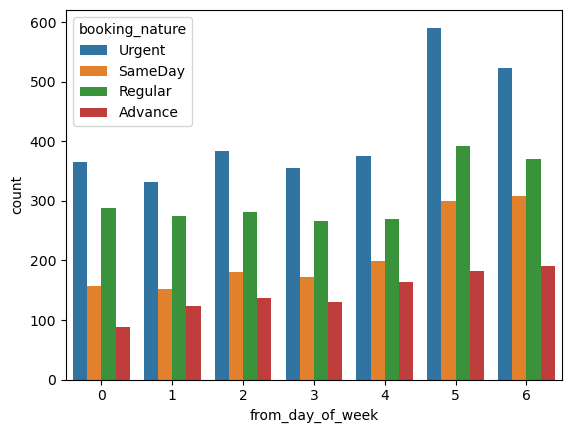

In [124]:
# It is doing group by on day_of_week and booking_nature and displaying counts 
sns.countplot(x='from_day_of_week',hue='booking_nature',data=travel_type_3)
plt.show()

In [125]:
travel_type_3.from_area_car_cancellation_level = travel_type_3.from_area_car_cancellation_level.str.strip().str.lower().map({"zero":1,"low":2,"medium":3,"high":4})
travel_type_3.booking_nature = travel_type_3.booking_nature.map({"Urgent":1,"SameDay":2,"Regular":3,"Advance":4})
travel_type_3.from_time_of_day = travel_type_3.from_time_of_day.map({"Morning":1,"Afternoon":2,"Evening":3,"Night":4})
travel_type_3

,package_id,online_booking,mobile_site_booking,Car_Cancellation,is_VMID_12,from_area_car_cancellation_level,from_month,from_day_of_week,from_is_weekend,from_hour,from_time_of_day,time_diff,booking_nature
8,2.0,0,0,0,0,2,1,1,0,16,2,6.266667,2
20,2.0,0,0,0,0,2,1,1,0,14,2,1.633333,1
23,1.0,0,0,0,1,2,1,1,0,16,2,1.850000,1
34,1.0,1,0,0,1,2,1,1,0,20,3,2.583333,1
47,2.0,0,0,0,1,2,1,2,0,3,4,7.383333,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43415,1.0,0,1,0,1,1,11,6,1,16,2,3.466667,2
43417,4.0,0,0,0,1,1,11,6,1,15,2,1.900000,1
43420,2.0,1,0,0,0,1,11,0,0,1,4,11.100000,3
43424,2.0,0,0,0,1,2,11,6,1,15,2,0.866667,1


In [126]:
travel_type_3.drop(columns=['time_diff'], inplace=True)

### Machine Learning

#### Stacking classifier

In [127]:
x_train,x_test,y_train,y_test = train_test_split(travel_type_3.drop(columns=['Car_Cancellation'],axis=1), travel_type_3['Car_Cancellation'],test_size=0.2, random_state=20)

In [128]:
y_train.value_counts()

Car_Cancellation
0    5772
1     268
Name: count, dtype: int64

In [129]:
y_test.value_counts()

Car_Cancellation
0    1442
1      68
Name: count, dtype: int64

In [130]:

# Step 1: Define base models (level-0)
base_models = [
    ('dt', DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('svc', SVC(class_weight='balanced', probability=True, random_state=42))  # probability=True required for stacking
]

# Step 2: Define meta-model (level-1)
meta_model = LogisticRegression()

# Step 3: Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # cross-validation for level-1 training
)

# Step 4: Fit on training data
stacking_model.fit(x_train, y_train)

# Step 5: Predict
ytrainpred_stack = stacking_model.predict(x_train)
ytestpred_stack = stacking_model.predict(x_test)

# Step 6: Evaluate
print("Train Report:\n", classification_report(y_train, ytrainpred_stack))
print("Test Report:\n", classification_report(y_test, ytestpred_stack))

Train Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5772
           1       0.88      0.56      0.68       268

    accuracy                           0.98      6040
   macro avg       0.93      0.78      0.83      6040
weighted avg       0.98      0.98      0.97      6040

Test Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1442
           1       0.69      0.13      0.22        68

    accuracy                           0.96      1510
   macro avg       0.83      0.56      0.60      1510
weighted avg       0.95      0.96      0.94      1510



### Voting Classifier

In [131]:
# Step 1: Define base models
clf_dt = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
clf_svc = SVC(probability=True, random_state=42)  # probability=True for soft voting

# Step 2: Create Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('decision_tree', clf_dt),
        ('random_forest', clf_rf),
        ('svm', clf_svc)
    ],
    voting='hard'  # use 'hard' if you don’t want to use probabilities
)

# Step 3: Train on training set
ensemble_model.fit(x_train, y_train)

# Step 4: Predict
ytrainpred_ens = ensemble_model.predict(x_train)
ytestpred_ens = ensemble_model.predict(x_test)

# Step 5: Evaluate
print("Train Report:\n", classification_report(y_train, ytrainpred_ens))
print("Test Report:\n", classification_report(y_test, ytestpred_ens))


Train Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5772
           1       0.97      0.84      0.90       268

    accuracy                           0.99      6040
   macro avg       0.98      0.92      0.95      6040
weighted avg       0.99      0.99      0.99      6040

Test Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1442
           1       0.56      0.15      0.23        68

    accuracy                           0.96      1510
   macro avg       0.76      0.57      0.61      1510
weighted avg       0.94      0.96      0.94      1510



#### Random Forest Algorithm

In [132]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [133]:
ytest_pred = rf.predict(x_test)
ytrain_pred = rf.predict(x_train)
print("Train Report:\n", classification_report(y_train, ytrain_pred))
print("Test Report:\n", classification_report(y_test, ytest_pred))


Train Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5772
           1       0.94      0.87      0.91       268

    accuracy                           0.99      6040
   macro avg       0.97      0.94      0.95      6040
weighted avg       0.99      0.99      0.99      6040

Test Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1442
           1       0.59      0.24      0.34        68

    accuracy                           0.96      1510
   macro avg       0.78      0.61      0.66      1510
weighted avg       0.95      0.96      0.95      1510



In [134]:
from sklearn.metrics import log_loss, brier_score_loss

In [136]:
y_pred_proba = rf.predict_proba(x_test)[:, 1]

# Compute Log-loss
logloss_value = log_loss(y_test, y_pred_proba)

# Compute Brier score
brier_value = brier_score_loss(y_test, y_pred_proba)

print("Log-loss:", logloss_value)
print("Brier score:", brier_value)

Log-loss: 0.2555229858523667
Brier score: 0.03468797398410683


#### Log Loss - Measures how well your predicted probabilities match the true labels. Penalizes confident wrong predictions heavily. Lower the better
#### Brier Score - It’s basically the mean squared error between predicted probability and actual outcome. Lower the better
#### Since the Log loss and brier score is a good one we can go ahead with either

### Still, before/after deploying it in <b> production </b> check on below points:
#### <b>a</b>. Test on more samples
#### <b>b</b>. Try more algorithms
#### <b>c</b>. Continuous monitoring of the model for any data distribution shift
#### <b>d</b>. Hyperparameters tuning
#### <b>e</b>. Adjusting weights for imbalanced classes(if any)